<a href="https://colab.research.google.com/github/Vixuz144/Robin-Hood/blob/main/Robin_Hood%5BES%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema  

 Supongamos que en el bosque de Sherwood el radio medio de un árbol es $R = 1 m$ y el número medio de árboles por unidad de superficie es $Σ = 0,005  m^2$. Si Robin Hood lanza una flecha en una dirección aleatoria, ¿qué distancia media recorrerá antes de chocar contra un árbol?


#Simulación con bosque Generado con una uniforme bivariada.

1. El primer paso es definir las variables que intervienen en el problema.

* $X, Y ∼ U[-l,l]$

Donde $l$ es la mitad de la longitud del lado de un cuadrado.

Además, se considerarán que todos los radios de los árboles son constantes, para nuestro ejemplo consideraremos que el radio será 1.

2. En adición, las funciones de densidad de probabilidad de estas dos variables son:

$$ f_X(x) = \frac{1}{2l}, \quad \textrm{para } -l \leq x \leq l, \ x\in\mathbb{R} $$

$$ f_Y(y) = \frac{1}{2l}, \quad \textrm{para } -l \leq y \leq l, \ y\in\mathbb{R} $$

3. Y las funciones de densidad acumulada de ambas variables son:

$$ F_X(x) = \frac{x+l}{2l}, \quad \textrm{para } -l \leq x \leq l, \ x\in\mathbb{R} $$

$$ F_Y(y) = \frac{y+l}{2l}, \quad \textrm{para } -l \leq y \leq l, \ y\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [118]:
from random import random, seed
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [119]:
@jit(nopython = True)
def bosque_flecha(a, b, ra, n):
  X = a+(b-a)*np.random.random(n)
  Y = a+(b-a)*np.random.random(n)

  pos = np.equal(X>0, True*np.ones(n))
  R = ra * np.ones_like(Y)
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  Xf, Yf, Rf = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Yf)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Yf[i]) <= Rf[i]:
      x, y, r = Xf[i], Yf[i], Rf[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = b
  return X, Y, x, y, d

Esta función genera la posición de los centros de los árboles con dos distribuciones uniformes en $[a, b]$. Además de proporcionar los radios constantes de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$.

* Entradas:
  * a: límite inferior de distribución uniforme.
  * b: límite snferior de distribución uniforme.
  * ra: radio constante de los árboles.
  * n: cantidad de árboles a generar.


* Salidas:
  * X: lista con las abscisas de las coordenadas de los centros de los árboles.
  * Y: lista con las ordenadas de las coordenadas de los centros de los árboles.
  * x: flotante, abscisa de las coordenada del centro del árbol con el que impactó la felcha.
  * y: flotante, ordenada de las coordenada del centro del árbol con el que impactó la flecha.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación y los radios de los árboles son 1 constante.

Para poder generar la cantidad de árboles a partír del parámetro de la densidad de árboles en área es necesario despejar la amplitud del intervalo ("radio del bosque") o la cantidad de árboles a generar.

In [120]:
ρ = 0.005
r = 400
d = 2*r
n = int(ρ*d**2)

In [121]:
# ρ = 0.005
# n = 1000
# r = ρ*n/2

Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

La flecha impactó en el arbol con coordenadas (95.91445967485555,-0.9055387951025864). La flecha recorrió 95.49019620651994m


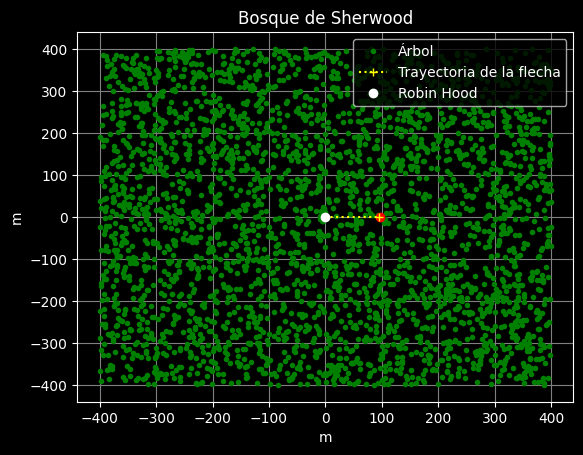

In [122]:
ra = 1
X, Y, x, y, d = bosque_flecha(-r, r, ra, n)

print(f'La flecha impactó en el arbol con coordenadas ({x},{y}). La flecha recorrió {d}m')

plt.style.use('dark_background')

plt.plot(X,Y, '.g', label='Árbol')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria de la flecha')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Primera_graf')
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [123]:
@jit(nopython = True)
def experimento(ρ, r, ra=1, n = 10**4):
  na = int(ρ*(2*r)**2)
  l = []
  for i in range(n):
    d = bosque_flecha(-r, r, ra, na)[-1]
    l.append(d)
  return l

Se establecen lo parámetros de entrada de la función.

In [124]:
densidad = 0.005
r = 400
ra = 1
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [125]:
l = experimento(densidad, r, ra, n)

In [126]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(n)}, {m + z*ds/np.sqrt(n)}]')

El intervalo de confianza del 95% es [92.153428121066, 103.82813659676025]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [127]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

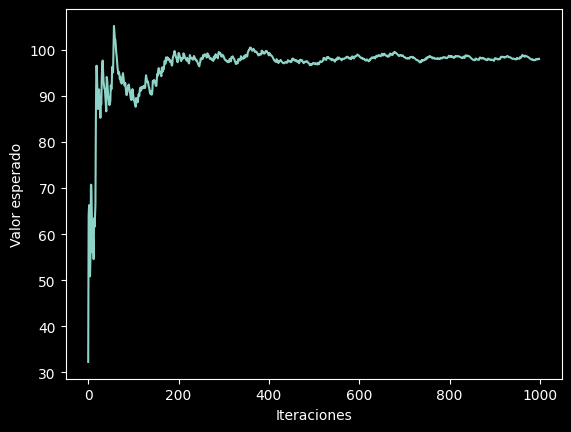

In [128]:
ls = graf(l)

plt.plot(ls)
plt.xlabel('Iteraciones')
plt.ylabel('Valor esperado')
plt.savefig('Segunda_graf')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol,así como un intervalo de confianza final con un nivel de confianza del 95%.

In [129]:
@jit(nopython = True)
def rep(ρ, r, ra, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, r, ra, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [130]:
nr = 10**3
l = rep(densidad, r, ra, 400, nr)

In [131]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
li = m - z*ds/np.sqrt(nr)
ls = m + z*ds/np.sqrt(nr)
print(f'El intervalo de confianza del 95% es [{li}, {ls}]')
print(f'E[distancia recorrida por la flecha] = {m}')

El intervalo de confianza del 95% es [97.31378014051394, 97.88152425301682]
E[distancia recorrida por la flecha] = 97.59765219676538


Además, se agrega un histograma para visualizar el comportamiento de las repeticiones del experimento. Lo que nos genera una campana de Gauss aproximada.

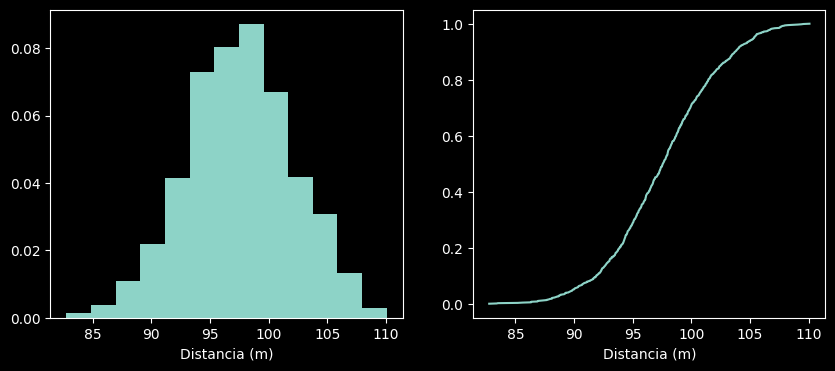

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson con un radio de bosque, radios de lo árboles constantes.

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas cartesianas.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood.

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

2. En adición, las funcioness de densidad de probabilidad de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$



3. Y las funciones de distribución de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles. Para lo cual haremos uso de la siguiente función.

In [133]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [134]:
@jit(nopython = True)
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(2*np.pi*random())
    i += 1

  return R, θ

Esta función genera el proceso de Poisson bivariado.

* Entradas:
  * r: Radio del circulo dentro del cual se generarán los arboles. Debe ser un flotante positivo.
  * ρ: Parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser flotante positivo.


* Salidas:
  * X: Lista con las abscisas de las coordenadas de los árboles.
  * Y: Lista con las ordenadas de las coordenadas de los árboles.

4. Ahora, veamos la ejecución de la función. Para ello consideraremos un radio de $100m$ y una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación.

In [135]:
radio = 100
densidad = 0.005

In [136]:
seed(144)
R, θ = bosque(radio, densidad)
X = R*np.cos(θ)
Y = R*np.sin(θ)

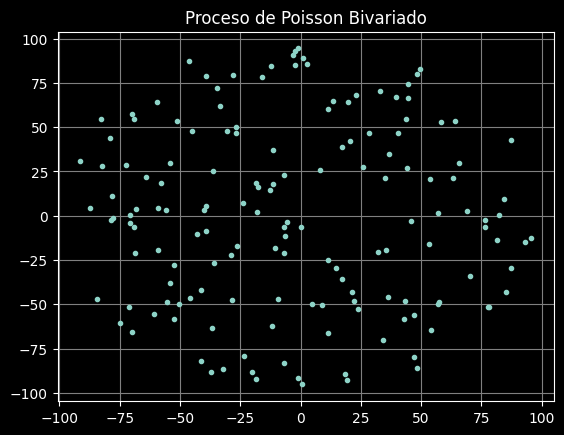

In [137]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Proceso de Poisson Bivariado')
plt.grid(color='gray')
plt.show()

5. Implementación del arquero, Robin Hood.

Para este punto, ya tenemos la una pequeña parte de nuestra simulación armada. Ahora, vamos a agregar a nuestro coprotagonista del problema, Robin Hood. Para ello vamos a considerar que este famoso arquero se localiza en el centro de nuestro bosque de Sherwood. Y al lanzar una flecha en una dirección (cartesiana) aleatoria podrá impactarse y quedar fija en algún árbol. Ahora la problemática está en ¿Cómo sabremos que la flecha queda incrustada o no en el árbol?.

Para ello tendremos que saber que dimensiones tiene el árbol. Para lo cual consideremos de momento que el tronco del árbol es un cilindro de radio $r_a$. Con lo cual si la dirección de la flecha se intersecta con una circunferencia de radio $r_a$ con centro en las cordenadas de un árbol, habrá impactado con el árbol y diremos que ahí fue donde terminó la flecha tras el lanzamiento.

Para programar esto, haremos uso de pequeños trucos Para ahorrar recursos computacionales.
* Primero, en lugar de disparar una flecha en una dirección aleatoria vamos a dispararla en la dirección del eje positivo $x$, es decir, con dirección $(1, 0)$. esto ya que al generar un bosque aleatorio cada vez, será como haber elegido una dirección por la misma pseudo-aleatoriedad del proceso de Poisson.
* Con ésta implementación ahora solo queda decidir cuando la flecha ha impactado con el árbol. Para lo cual descartarémos todos los árboles que tengan coordenadas negativas en su abscisa. Ya que no podrá llegar la flecha en esa dirección a menos que rebote.
* Luego, en lugar de calcular la circunferencia de cada uno de los árboles, unicamente comprobarémos si la flecha pasa sí suficientemente cerca de los árboles. Para ello compararémos el radio de cada árbol en la media circunferencia con la distancia que hay del centro del árbol (coordenadas generadas por el proceso de Poisson) a la flecha, de manera que si la distancia es menor al radio la flecha habrá impactado, y en caso de que la distancia sea mayor al radio la flecha no habrá impactado.
* Y el truquito final será como calcular la distancia del centro del árbol a la flecha, el cual será fácil gracias a tomar la dirección de la flecha como el eje $x$ positivo. Ya que se despreciará la coordenada en $x$ del árbol y de la flecha, resultando en que la distancia será el valor absoluto de la coordenada en $y$ del árbol.

Lo único que resta antes de codificar estos trucos será considerar que la flecha se detiene cuando impacte el primer árbol. Por lo cual Robin deberá ir por su fleha hasta ese árbol en caso de querer recuperarla.

In [138]:
@jit(nopython = True)
def disparo_flecha(X, Y, R, max_dist):
  # X, Y = np.array(abscisas), np.array(ordenadas)
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  X, Y, R = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Y)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Y[i]) <= R[i]:
      x, y, r = X[i], Y[i], R[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = max_dist
  return x, y, d

La flecha impactó en el arbol con coordenadas (82.1245600401645,0.4285298167515038). La flecha recorrió 81.22103240021377m


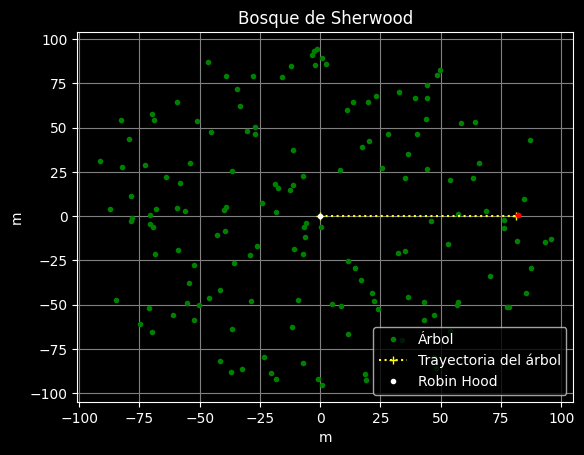

In [139]:
r_a = 1 * np.ones(len(X))
x, y, d = disparo_flecha(X, Y, r_a, radio)

print(f'La flecha impactó en el arbol con coordenadas ({x},{y}). La flecha recorrió {d}m')

plt.plot(X, Y, '.g', label='Árbol')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria del árbol')
plt.plot(x, y, '.r')
plt.plot(0, 0, '.w', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Tercera_graf')
plt.show()

6. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [140]:
def experimento(R, ρ, r_a, n = 10**4):
  l = []
  for i in range(n):
    r, t = bosque(R, ρ)
    x = r*np.cos(t)
    y = r*np.sin(t)
    lra = r_a * np.ones(len(x))
    _, _, d = disparo_flecha(x, y, lra, R)
    l.append(d)
  return l

In [141]:
radio = 320
densidad = 0.005
r_a = 1
n = 10**3

In [142]:
l = experimento(radio, densidad, r_a, n)

In [143]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

El intervalo de confianza del 95% es [91.23596727340703, 102.11418701055828]


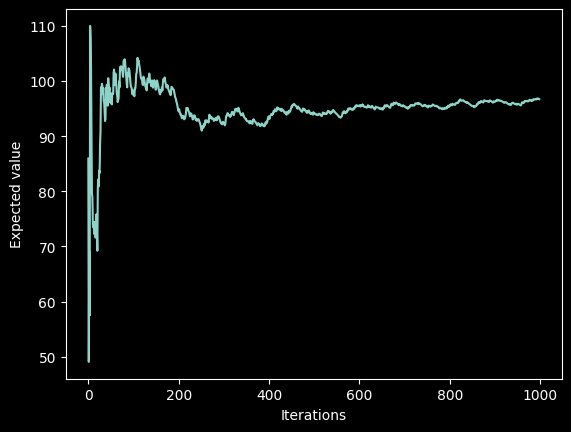

In [144]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected value')
plt.savefig('Cuarta_graf')
plt.show()

Sin ambargo, el limitar el proceso de Poison bivariado a una circunferencia de radio $\mathcal{R}=320$ tiene como consecuencia que en algunos lanzamientos la flecha sale de la circunferencia, lo cual podemos interpretar como que la flecha recorió más de 320m. lo cual al hacer un pequeño recuento se siene que...

In [145]:
print(f'... hay un {100 * l.count(radio)/len(l)}% de flechas que recorren {radio}m y no impactan con ningún arbol')

... hay un 3.9% de flechas que recorren 320m y no impactan con ningún arbol


7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar.

In [146]:
def rep(R, ρ, r_a, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(R, ρ, r_a, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [147]:
nr = 400
l = rep(radio, densidad, r_a, n = 400, n_rep = nr)

In [148]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'Y el valor esperado de la distancia recorrida por la flecha es {m}')

El intervalo de confianza del 95% es [95.03875303876582, 95.85467807710101]
Y el valor esperado de la distancia recorrida por la flecha es 95.44671555793342


Además, se agregan un par de gráficas que nos muestran la naturaleza del comportamiento de la distancia recorrida por la flecha a travéz de las repeticiones del experimento.

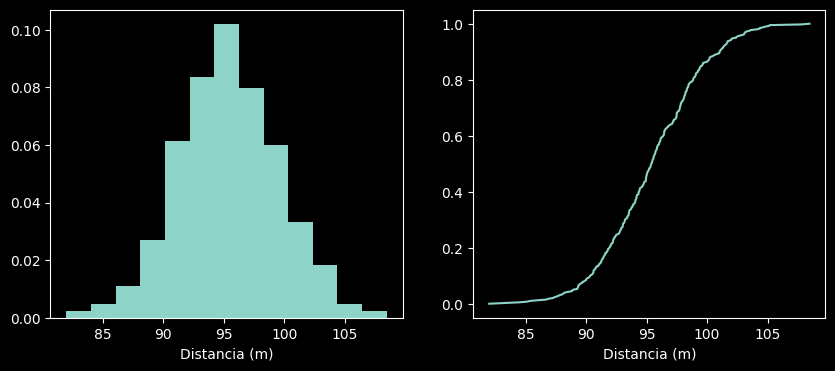

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson con un radio de bosque, radios de lo árboles uniformes.

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas rectangulares.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerará una distribución uniforme en $[0,2]$ para los radios de los árboles.

* $r_a ∼ U(0, 2) $

2. En adición, las funcioness de densidad de probabilidad de estas tres variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ f_{r_a}(x) = \frac{1}{2}, \quad \textrm{para } x \in [0, 2], \ x\in\mathbb{R} $$



3. Y las funciones de distribución de estas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ F_{r_a}(x) = \frac{x}{2}, \quad \textrm{para } x \in [0, 2], \ x\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles. Para lo cual haremos uso de la siguiente función.

In [150]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [151]:
@jit(nopython = True)
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(2*np.pi*random())
    i += 1

  return R, θ

Esta función genera el proceso de Poisson bivariado.

* Entradas:
  * r: radio del circulo dentro del cual se generarán los arboles. Debe ser un número real positivo.
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser un número real positivo.


* Salidas:
  * X: lista con las abscisas de las coordenadas de los árboles.
  * Y: lista con las ordenadas de las coordenadas de los árboles.

Además,para generar los radios de los árboles, usaremos la siguiente función.

In [152]:
@jit(nopython = True)
def radios_unif(n, a = 0, b = 2):
  return a + (b-a) * np.random.random(n)

Esta función genera una array de radios con distribución uniforme.
* Entradas:
  * n: cantidad de números aleatorios a generar, cantidad de árboles.
  * a: límte inferior del intervalo para generar números aleatorios, el rádio más pequeño que se puede obtener.
  * b: límte superior del intervalo para generar números aleatorios, el rádio más grande que se puede obtener.
* Salidas:
  * r_a: Lista de los radios de los árboles con distribución uniforme.

4. Ahora, veamos la ejecución de la función. Para ello consideraremos un radio de $100m$ y una densidad de $0.005\frac{árboles}{m^2}$ para nuestra simulación.

In [153]:
radio = 100
densidad = 0.005

In [154]:
R, θ = bosque(radio, densidad)
X = R*np.cos(θ)
Y = R*np.sin(θ)

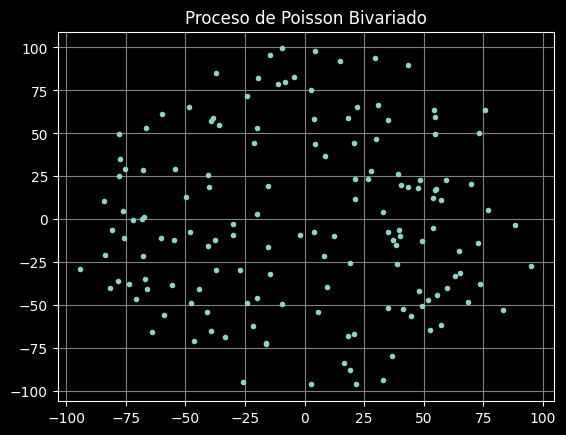

In [155]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Proceso de Poisson Bivariado')
plt.grid(color='gray')
plt.show()

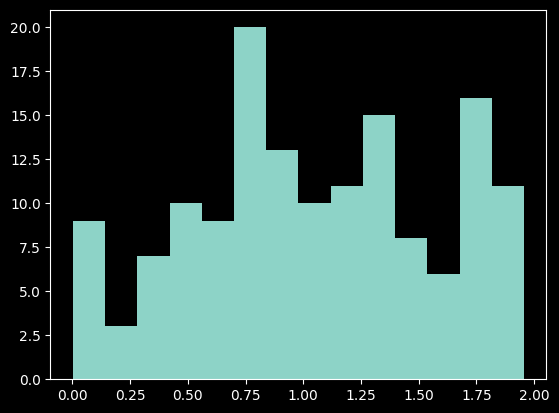

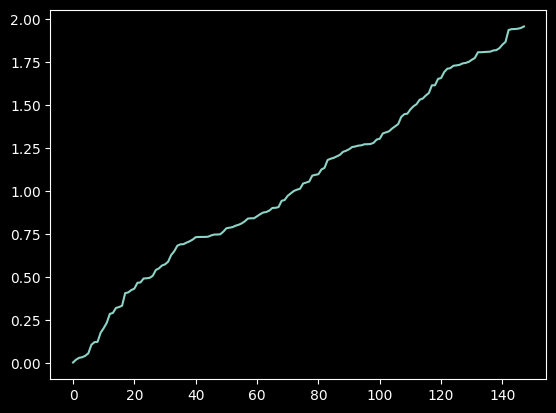

In [156]:
l = radios_unif(len(X))
plt.hist(l, bins = 14)
plt.show()

plt.plot(np.sort(l))
plt.show()

5. Implementación del arquero, Robin Hood.

Nuevamente, necesitamos implementar el disparo de la flecha efectuado por Robin Hood. Para ello se considera que este famoso arquero se localiza en el centro del bosque de Sherwood. Y al lanzar una flecha en una dirección aleatoria podrá impactarse y quedar fija en algún árbol. Para lo cual haremos uso de las condiciones ya antes explicadas:

* Primero, en lugar de disparar una flecha en una dirección aleatoria vamos a dispararla en la dirección del eje positivo $x$, es decir, con dirección $(1, 0)$. esto ya que al generar un bosque aleatorio cada vez, será como haber elegido una dirección por la misma pseudo-aleatoriedad del proceso de Poisson.
* Con ésta implementación ahora solo queda decidir cuando la flecha ha impactado con un árbol. Para lo cual descartarémos todos los arboles que tengan coordenadas negativas en su abscisa. Ya que no podrá llegar la flecha en esa dirección.
* Luego, en lugar de calcular la circunferencia de cada uno de los árboles, unicamente comprobarémos si la flecha pasa suficientemente cerca de los árboles. Para ello compararémos el radio de cada árbol en la media circunferencia con la distancia que hay del centro del árbol (coordenadas generadas por el proceso de Poisson) a la flecha, de manera que si la distancia es menor al radio la flecha habrá impactado, y en caso de que la distancia sea mayor al radio la flecha no habrá impactado.
* Y el truquito final será como calcular la distancia del centro del árbol a la flecha, el cual será fácil gracias a tomar la dirección de la flecha como el eje $x$ positivo. Ya que se despreciará la coordenada en $x$ del árbol y de la flecha, resultando en que la distancia será el valor absoluto de la coordenada en $y$ del árbol.

Lo único que resta antes de codificar estos trucos será considerar que la flecha se detiene cuando impacte el primer árbol. Por lo cual Robin deberá ir por su flecha hasta ese árbol en caso de querer recuperarla.

In [157]:
@jit(nopython = True)
def disparo_flecha(X, Y, R, max_dist):
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  X, Y, R = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Y)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Y[i]) <= R[i]:
      x, y, r = X[i], Y[i], R[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = max_dist
  return x, y, d

La función *disparo_flecha* simula el disparo de la flecha de Robin Hood, considerando los "trucos" antes mencionados.
* Entradas:
  * X: lista de abscisas de las coordenadas de los árboles.
  * Y: lista de ordenadas de las coordenadas de los árboles.
  * R: lista de los radios de los árboles.
  * max_dist: Máxima distancia que recorrerá el tiro o radio del bosque.
* Salidas
  * x: abscisa del arbol enque impactó la flecha.
  * y: ordenada del arbol enque impactó la flecha.
  * d: distancia que recorrió la flecha hasta impactar con la cortesa árbol.

La flecha impactó en el arbol con coordenadas (0.0,0.0). La flecha recorrió 100.0m


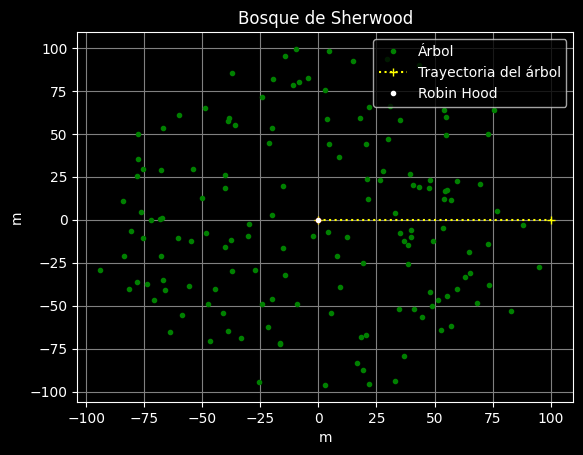

In [158]:
r_a = radios_unif(len(X))
x, y, d = disparo_flecha(X, Y, r_a, radio)

print(f'La flecha impactó en el arbol con coordenadas ({x},{y}). La flecha recorrió {d}m')

plt.plot(X, Y, '.g', label='Árbol')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria del árbol')
plt.plot(x, y, '.r')
plt.plot(0, 0, '.w', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.show()

6. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [159]:
def experimento(R, ρ, r_dist, n = 10**4):
  l = []
  for i in range(n):
    r, t = bosque(R, ρ)
    x = r*np.cos(t)
    y = r*np.sin(t)
    try:
      m, s = r_dist
    except:
      m = 0
      s = r_dist
    lr = radios_unif(len(x), m, s)
    _, _, d = disparo_flecha(x, y, lr, R)
    l.append(d)
  return l

In [160]:
radio = 320
densidad = 0.005
rd = (0,2)
n = 10**3

In [161]:
l = experimento(radio, densidad, rd, n)

In [162]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

El intervalo de confianza del 95% es [89.78985570331243, 100.10757154463103]


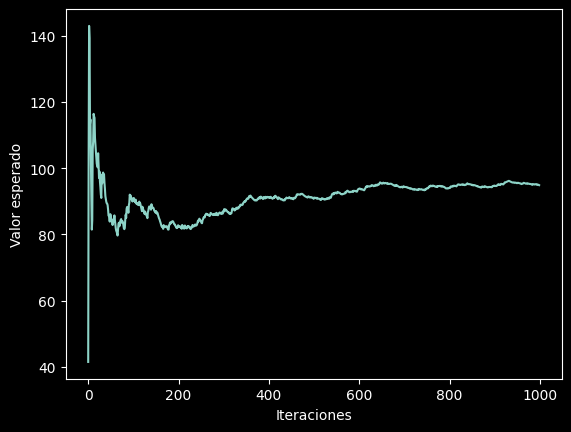

In [163]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

ls = graf(l)

plt.plot(ls)
plt.xlabel('Iteraciones')
plt.ylabel('Valor esperado')
plt.savefig('Quinta_graf')
plt.show()

In [164]:
print(f'Hay un {100 * l.count(radio)/len(l)}% de flechas que recorren {radio}m y no impactan con ningún arbol')

Hay un 4.0% de flechas que recorren 320m y no impactan con ningún arbol


7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar. Además de calcular un intervalo de confianza del 95%.

In [165]:
def rep(R, ρ, r_dist, n = 10**2, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(R, ρ, r_dist, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [166]:
nr = 10**2
l = rep(radio, densidad, rd, 400, nr)

In [167]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorrida por la flecha es {m}m')

El intervalo de confianza del 95% es [93.9443357079786, 95.61375612468926]
El valor esperado de la distancia recorrida por la flecha es 94.77904591633393m


Y finalmente se muestran un par de gráficas que muestran el comportamiento del proceso de repetición de los experimentos.

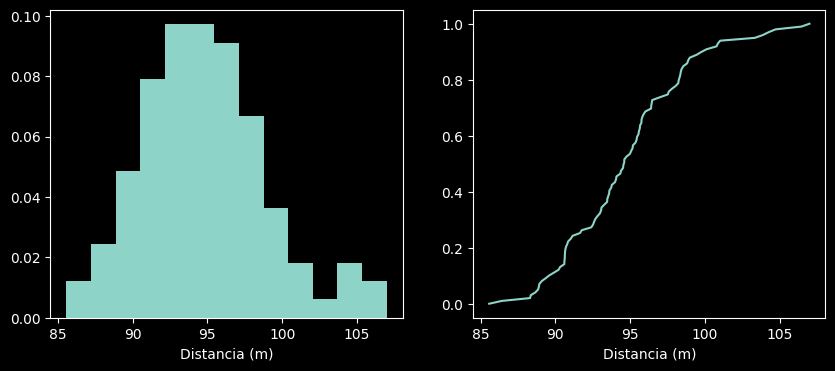

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson, radios de los árboles constantes

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas cartesianas.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood.

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerarán que todos los radios de los árboles son constantes, para nuestro ejemplo consideraremos que el radio será 1.

2. En adición, las funcioness de distribución de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Y las funciones de distribución acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [169]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [170]:
@jit(nopython = True)
def bosque_flecha(ρ, r = 1):
  n = 0
  X = []
  R = []
  θ = []
  while True:
    n += 1
    X.append(-np.log(random())/ρ)
    R.append(np.sqrt(sum(X)/np.pi))
    θ.append(2*np.pi*random())
    if R[-1]*abs(np.sin(θ[-1])) < r and  R[-1]*np.cos(θ[-1]) > 0:
      break

  d = R[-1] - r

  return R, θ, d

Esta función genera el proceso de Poisson bivariado. Además de generar los radios de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$. El proceso de Poisson bivariado se detiene hasta que se genere un punto en el espacio (árbol) que impacte con el disparo, lo cual se comprueba la distancia del árbol con el radio de dicho árbol.

* Entradas:
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser un número real positivo.
  * r: radio constante de los árboles. Debe ser un número real positivo.


* Salidas:
  * R: lista con las radios de las coordenadas polares de los arboles.
  * θ: lista con las ángulos (radianes) de las coordenadas polares de los arboles.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación y que los radios de los árboles son constantes, con radio de 1 metro.

In [171]:
densidad = 0.005
r = 1

In [172]:
R, θ, d = bosque_flecha(densidad, r)
X = R*np.cos(θ)
Y = R*np.sin(θ)
x, y = X[-1], Y[-1]

print(f'El disparo de la flecha recorió {d}m hasta impactar con el árbol centrado en ({x},{y}) y con radio {r}m')

El disparo de la flecha recorió 109.00006219327048m hasta impactar con el árbol centrado en (109.9988380096315,-0.5189595882379383) y con radio 1m


Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

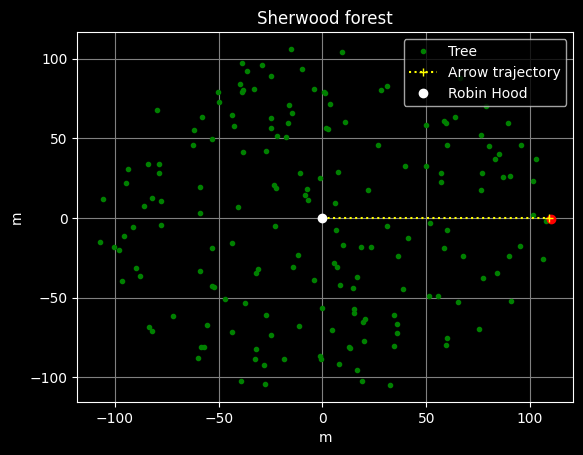

In [173]:
plt.style.use('dark_background')
plt.plot(X,Y, '.g', label='Árbol')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria de la flecha')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Sexta_graf')
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [174]:
@jit(nopython = True)
def experimento(ρ, r=1, n = 10**4):
  l = []
  for i in range(n):
    _, _, d = bosque_flecha(ρ,r)
    l.append(d)
  return l

Se establecen lo parámetros de entrada de la función.

In [175]:
densidad = 0.005
r = 1
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [176]:
l = experimento(densidad, r, n)

In [177]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(n)}, {m + z*ds/np.sqrt(n)}]')

El intervalo de confianza del 95% es [94.72092305110128, 107.16286294502719]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [178]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

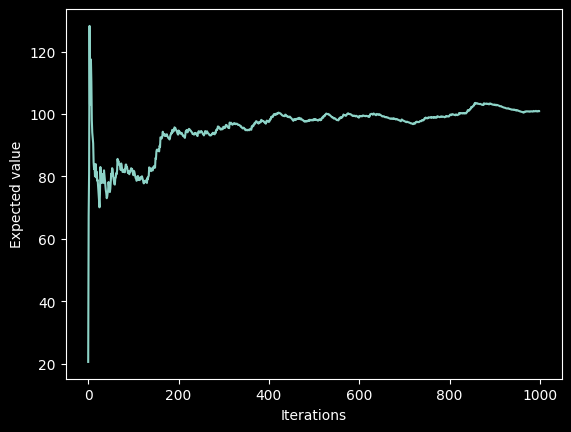

In [179]:
ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected value')
plt.savefig('Septima_graf')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol. En adición a esto se tiene un intervalo de confianza del 95%.

In [180]:
@jit(nopython = True)
def rep(ρ, r, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, r, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [181]:
nr = 10**3
l = rep(densidad, r, 400, nr)

In [182]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(nr)}, {m + z*ds/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorida por la flecha es {m}m')

El intervalo de confianza del 95% es [98.83465888660668, 99.46195402079097]
99.14830645369882


Además, para una mejor visualización la distribución de las repeticiones de los experimentos es que agregamos las siguientes gráficas.

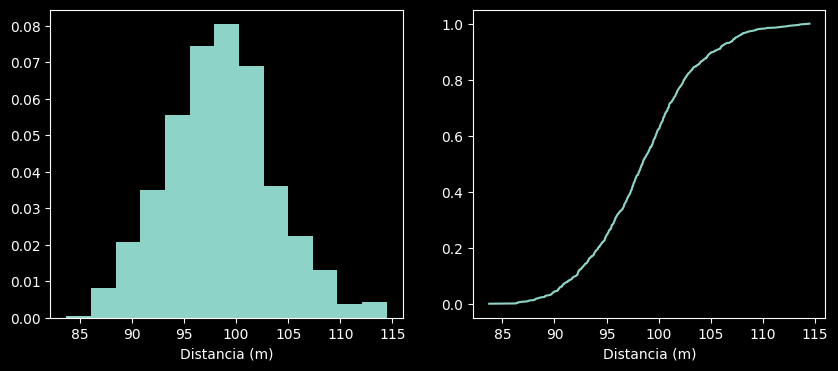

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson, radios de los árboles uniformes

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas cartesianas.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerará una distribución uniforme en $[a,b]$ para los radios de los árboles.

* $r_a ∼ U(a, b) $

2. En adición, las funcioness de densidad de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ f_{r_a}(x) = \frac{1}{b-a}, \quad \textrm{para } x \in [a, b], \ x\in\mathbb{R} $$

3. Y las funciones de densidad acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ F_{r_a}(x) = \frac{x-a}{b-a}, \quad \textrm{para } x \in [a, b], \ x\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [183]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [184]:
@jit(nopython = True)
def bosque_flecha(ρ, a=0, b=2):
  n = 0
  X = []
  R = []
  θ = []
  r = []
  while True:
    n += 1
    X.append(-np.log(random())/ρ)
    R.append(np.sqrt(sum(X)/np.pi))
    θ.append(2*np.pi*random())
    r.append(a + (b-a)*random())
    if R[-1]*abs(np.sin(θ[-1])) < r[-1] and  R[-1]*np.cos(θ[-1]) > 0:
      break

  d = R[-1] - r[-1]

  return R, θ, r, d

Esta función genera el proceso de Poisson bivariado. Además de generar los radios de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$. El proceso de Poisson bivariado se detiene hasta que se genere un punto en el espacio (árbol) que impacte con el disparo, lo cual se comprueba la distancia del árbol con el radio de dicho árbol.

* Entradas:
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de árboles en el bosque de Sherwood. Debe ser un número real positivo.
  * a: límite inferior del intervalo de generación de números aleatorios uniformes, el rádio más pequeño que puede tener un árbol.
  * b: límite superior del intervalo de generación de números aleatorios uniformes, el rádio más grande que puede tener un árbol.


* Salidas:
  * R: lista con las radios de las coordenadas polares de los árboles.
  * θ: lista con las ángulos (radianes) de las coordenadas polares de los árboles.
  * r: lista de los rádios de los árboles.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación y que los radios de los árboles tienen una distribución uniforme en $[0,2]$.

In [185]:
densidad = 0.005
a = 0
b = 2

In [186]:
R, θ, r, d = bosque_flecha(densidad, a, b)
X = R*np.cos(θ)
Y = R*np.sin(θ)

x, y = X[-1], Y[-1]
print(f'El disparo de la flecha recorió {d}m hasta impactar con el árbol centrado en ({x},{y}) y con radio {r[-1]}')

El disparo de la flecha recorió 27.989066561620543m hasta impactar con el árbol centrado en (29.77877066408772,-0.8524246754629032) y con radio 1.8019020378001427


Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

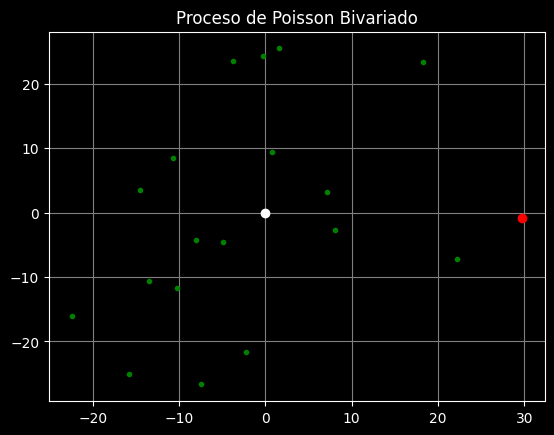

In [187]:
plt.style.use('dark_background')
plt.plot(X,Y, '.g', label='Árbol')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria de la flecha')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [188]:
@jit(nopython = True)
def experimento(ρ, a=0, b=2, n = 10**4):
  l = []
  for i in range(n):
    _, _, _, d = bosque_flecha(ρ, a, b)
    l.append(d)
  return l

La función hace el "experimento" de general un bosque aleatorio, disparar una flecha y registrar la distancia recorrida por la flecha hasta impactar con un árbol.
* Entradas:
  * ρ: flotante, parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser positivo.
  * a: flotante, límite inferior del intervalo de generación de números aleatorios uniformes, el rádio más pequeño que puede tener un árbol.
  * b: flotante, límite superior del intervalo de generación de números aleatorios uniformes, el rádio más grande que puede tener un árbol.
  * n: entero, número de repeticiones que se realizará el experimento.

* Salidas:
  * l: lista con las distancias recorridas por las flechas lanzadas en los n experimentos.

Se establecen lo parámetros de entrada de la función.

In [189]:
densidad = 0.005
a = 0
b = 2
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [190]:
l = experimento(densidad, a, b, n)

In [191]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

El intervalo de confianza del 95% es [95.91353695557427, 108.13687633371626]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [192]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

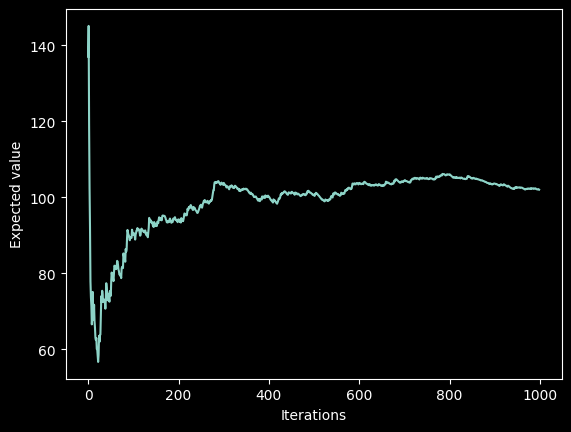

In [193]:
ls = graf(l)

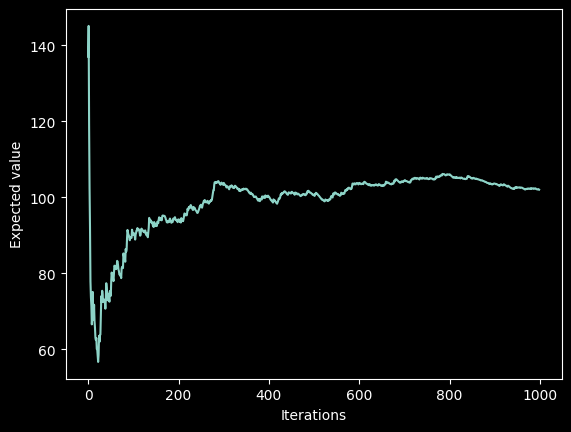

In [194]:
plt.plot(ls)
plt.xlabel('Iteraciones')
plt.ylabel('Valor esperado')
plt.savefig('Octava_gráfica')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol. Además de agregar un intervalo de confianza con un nivel de significancia de 0.05.

In [195]:
@jit(nopython = True)
def rep(ρ, a, b, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, a, b, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [196]:
nr=10**3
l = rep(densidad, a, b, n = 400, n_rep = nr)

In [199]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorida por la flecha es {m}m')

El intervalo de confianza del 95% es [98.21634426794652, 98.8506764948424]
El valor esperado de la distancia recorida por la flecha es 98.53351038139446m


Además, se muestran dos gráficas que nos permiten visualizar la distribución del comportamiento de los lanzamientos de flechas con el paso de las repeticiones de los experimentos.

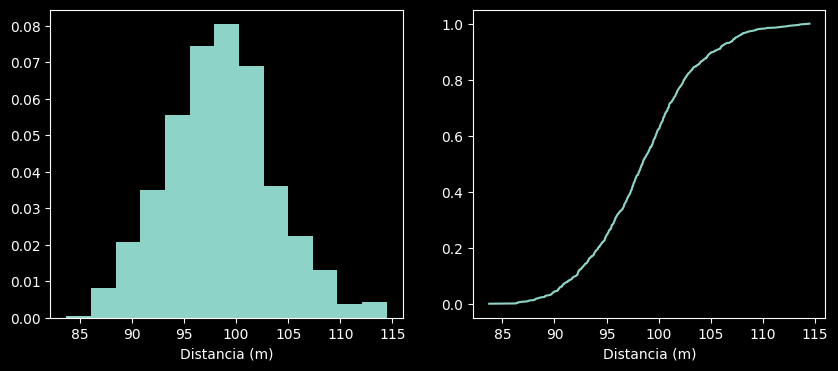

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()